<font size="2"> [github.com/jankoslavic/pypinm](http://github.com/jankoslavic/pypinm)</font>

[Prof. dr. Janko Slavič](http://www.ladisk.si/~slavic)

<center>
<img width=300 src="./fig/ladisk.png">
<br>
<font size="7" color="f00e0e" face="garamond"><b>Interpolacija</b></font>
<img src="">
<font size="2">November 2019</font>
</center>

<h1>Kazalo<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Uvod" data-toc-modified-id="Uvod-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Uvod</a></span></li><li><span><a href="#Interpolacija-s-polinomom" data-toc-modified-id="Interpolacija-s-polinomom-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Interpolacija s polinomom</a></span></li><li><span><a href="#Lagrangeva-metoda" data-toc-modified-id="Lagrangeva-metoda-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Lagrangeva metoda</a></span><ul class="toc-item"><li><span><a href="#Ocena-napake" data-toc-modified-id="Ocena-napake-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ocena napake</a></span></li><li><span><a href="#Zgled" data-toc-modified-id="Zgled-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Zgled</a></span></li><li><span><a href="#Zgled-ocene-napake" data-toc-modified-id="Zgled-ocene-napake-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Zgled ocene napake</a></span></li><li><span><a href="#Interpolacija-z-uporabo-scipy" data-toc-modified-id="Interpolacija-z-uporabo-scipy-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Interpolacija z uporabo <code>scipy</code></a></span></li></ul></li><li><span><a href="#Kubični-zlepki" data-toc-modified-id="Kubični-zlepki-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Kubični zlepki</a></span><ul class="toc-item"><li><span><a href="#Naravni-kubični-zlepki" data-toc-modified-id="Naravni-kubični-zlepki-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Naravni kubični zlepki</a></span></li><li><span><a href="#Numerična-implementacija" data-toc-modified-id="Numerična-implementacija-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Numerična implementacija</a></span></li></ul></li><li><span><a href="#Nekaj-vprašanj-za-razmislek!" data-toc-modified-id="Nekaj-vprašanj-za-razmislek!-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Nekaj vprašanj za razmislek!</a></span><ul class="toc-item"><li><span><a href="#Dodatno" data-toc-modified-id="Dodatno-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Dodatno</a></span></li><li><span><a href="#Nekaj-komentarjev-modula-scipy.interpolate" data-toc-modified-id="Nekaj-komentarjev-modula-scipy.interpolate-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Nekaj komentarjev modula <code>scipy.interpolate</code></a></span></li><li><span><a href="#Odvajanje,-integriranje-...-zlepkov" data-toc-modified-id="Odvajanje,-integriranje-...-zlepkov-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Odvajanje, integriranje ... zlepkov</a></span></li></ul></li></ul></div>

# Uvod

Pri **interpolaciji** izhajamo iz tabele (različnih) vrednosti $x_i, y_i$:

| $\mathbf{x}$  | $\mathbf{y}$  |
|:-:|:-:|
| $x_0$  | $y_0$  |
| $x_1$  | $y_1$  |
| $\dots$   | $\dots$ |
| $x_{n-1}$| $y_{n-1}$|

določiti pa želimo vmesne vrednosti. Če želimo določiti vrednosti zunaj območja $x$ v tabeli, govorimo o **ekstrapolaciji**.

V okviru **interpolacije** (angl. *interpolation*) točke povežemo tako, da predpostavimo neko funkcijo in dodamo pogoj, da funkcija *mora* potekati skozi podane točke. 

Pri **aproksimaciji** (angl. *approximation* ali tudi *curve fitting*) pa predpostavimo funkcijo, ki se čimbolj (glede na izbrani kriterij) prilega podatkom. 

Poglejmo si primer:

| $\mathbf{x}$  | $\mathbf{y}$  |
|:-:|:-:|
| 1.0  | 0.54030231  |
| 2.5  | -0.80114362  |
| 4.0   | -0.65364362 |

Pri interpolaciji izhajamo iz tabele vrednosti. Da bomo pozneje lahko enostavno prikazali napako, smo zgornjo tabelo generirali s pomočjo izraza $y = \cos(x)$!

Pripravimo numerični zgled; najprej uvozimo pakete:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Nato pripravimo tabelo ter prikaz:

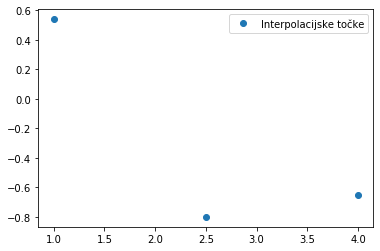

In [2]:
n = 3
x = np.linspace(1, 4, n)
f = np.cos # posplošimo interpolirano funkcijo (lahko spremenite v drugo funkcijo)
f_ime = f.__str__().split('\'')[1] # avtomatsko vzamemo ime funkcije
y = f(x)
plt.plot(x, y, 'o', label='Interpolacijske točke');
plt.legend();

# Interpolacija s polinomom

Interpolacija s polinomom se zdi najbolj primerna, saj je enostavna! 

Polinom stopnje $n-1$:
$$y = a_0\,x^{n-1} +a_1\,x^{n-2} +\cdots + a_{n-2}\,x + a_{n-1}.$$

je definiran z $n$ konstantami $a_i$. Da določimo $n$ konstant, potrebujemo $n$ (različnih) enačb. Za vsak par $x_i, y_i$ lahko torej zapišemo:
$$y_i = a_{0}\,x_i^{n-1} +a_{1}\,x_i^{n-2} +\cdots + a_{n-2}\,x_i + a_{n-1}.$$

Ker imamo podanih $n$ parov, lahko določimo $n$ neznanih konstant $a_i$, ki definirajo polinom stopnje $n-1$. Sistem $n$ linearnih enačb lahko zapišemo:
$$
\begin{bmatrix}
x_{0}^{n-1}&x_{0}^{n-2}&\dots&x_{0}^0\\
x_{1}^{n-1}&x_{1}^{n-2}&\dots&x_{1}^0\\
&&\vdots&&\\
x_{n-1}^{n-1}&x_{n-1}^{n-2}&\dots&x_{n-1}^0\\
\end{bmatrix}
\begin{pmatrix}
a_{0}\\
a_{1}\\
\vdots\\
a_{n-1}
\end{pmatrix}=
\begin{pmatrix}
y_{0}\\
y_{1}\\
\vdots\\
y_{n-1}
\end{pmatrix}
$$

Sistem linearnim enačb zapišemo v obliki:
$$\mathbf{M}\,\mathbf{a}=\mathbf{b}$$

Definirajmo matriko koeficientov $\mathbf{M}$:

In [3]:
M = np.asarray([[_**p for p in reversed(range(len(x)))] for _ in x])
M  

array([[ 1.  ,  1.  ,  1.  ],
       [ 6.25,  2.5 ,  1.  ],
       [16.  ,  4.  ,  1.  ]])

Izračunamo koeficiente $a_{0}, a_{1},\dots$:

In [4]:
resitev = np.linalg.solve(M, y)
resitev

array([ 0.33087687, -2.05236633,  2.26179176])

Pripravimo interpolacijski polinom kot Pythonovo funkcijo:

In [5]:
def y_function(x, resitev):
    A = np.asarray([[_**p for p in reversed(range(len(resitev)))] for _ in x])
    return A.dot(resitev)

Izris interpolacijskega polinoma pri bolj gosti mreži točk:

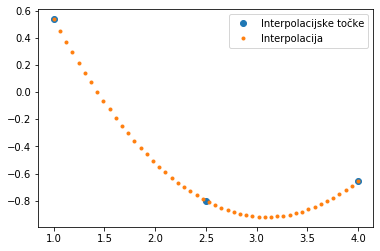

In [6]:
xint = np.linspace(np.min(x), np.max(x), 50)
yint = y_function(xint, resitev)
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(xint, yint, '.',label='Interpolacija')
plt.legend();

Slabosti zgornjega postopka so:

 * število numeričnih operacij raste sorazmerno z $n^3$,
 * problem je lahko slabo pogojen (z večanjem stopnje polinoma slaba pogojenost naglo narašča):

In [7]:
np.linalg.cond(M)

71.3022787031108

*Navodilo*: vrnite se par vrstic nazaj in spremenite število interpolacijskih točk $n$ na višjo vrednost (npr. 10).

# Lagrangeva metoda

*Lagrangeva* metoda ne zahteva reševanja sistema enačb in je s stališča števila računskih operacij (narašča sorazmerno z $n^2$ ([vir](http://www.ams.org/journals/mcom/1970-24-109/S0025-5718-1970-0258240-X/S0025-5718-1970-0258240-X.pdf))) boljša od predhodno predstavljene polinomske interpolacije (število operacij narašča sorazmerno z $n^3$), kjer smo reševali sistem linearnih enačb. Rešitev pa je seveda popolnoma enaka!

Lagrangev interpolacijski polinom stopnje $n-1$ je definiran kot:
$$P_{n-1}(x)=\sum_{i=0}^{n-1}y_i\,l_i(x),$$
kjer je $l_i$ Lagrangev polinom:
$$l_i(x)=\prod_{j=0, j\ne i}^{n-1} \frac{x-x_j}{x_i-x_j}.$$

Poglejmo si interpolacijo za zgoraj prikazane $x$ in $y$ podatke.

Definirajmo najprej Lagrangeve polinome $l_i(x)=\prod_{j=0, j\ne i}^{n-1} \frac{x-x_j}{x_i-x_j}$:

In [8]:
def lagrange(x, x_int, i):
    """ Vrne vrednosti i-tega Lagrangevega polinoma
    
    x: neodvisna spremenljivka (skalar ali numerično polje)
    x_int: seznam interpolacijskih točk
    i: indeks polinoma
    """
    Lx = 1.0
    for j in range(len(x_int)):
        if j != i:
            Lx *= (x-x_int[j]) / (x_int[i]-x_int[j])
    return Lx

In [9]:
def slika(i=0):
    xint = np.linspace(np.min(x), np.max(x), 30)
    plt.plot(x, y, 'o', label='Interpolacijske točke')
    plt.axhline(0, color='k', linewidth=0.3);
    plt.plot(xint, lagrange(xint, x_int=x, i=i), '.',label=f'Lagrangev polinom i={i}');
    for _ in x:
        plt.axvline(_, color='r', linewidth=0.5);
    plt.legend()
    plt.show()

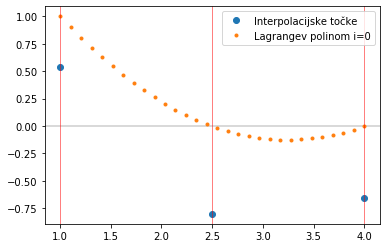

In [10]:
slika(i=0)

Opazimo, da ima $i$-ti Lagrangev polinom v $x_i$ vrednost 1, v ostalih podanih točkah pa nič!

Če torej Lagrangev polinom za $i=0$ pomnožimo z $y_0$, bomo pri $x=x_0$ dobili pravo vrednost, v ostalih interpolacijskih točkah pa nič; implementirajmo torej Lagrangev interpolacijski polinom:
$$P_{n-1}(x)=\sum_{i=0}^{n-1}y_i\,l_i(x),$$


In [11]:
def lagrange_interpolacija(x, x_int, y_int):
    """ Vrne vrednosti Lagrangeve interpolacije
    
    x: neodvisna spremenljivka (skalar ali numerično polje)
    x_int: abscisa interpolacijskih točk
    y_int: ordinata interpolacijskih točk
    """
    y = 0.
    for i in range(len(x_int)):
        Lx = 1.0
        for j in range(len(x_int)):
            if j != i:
                Lx *= (x-x_int[j]) / (x_int[i]-x_int[j])
        y += y_int[i] * Lx
    return y

Pripravimo sliko:

In [12]:
def slika(i=0):
    xint = np.linspace(np.min(x), np.max(x), 30)
    plt.plot(x, y, 'o', label='Interpolacijske točke')
    plt.plot(xint, lagrange(xint, x_int=x, i=i), '.',label=f'Lagrangev polinom i={i}');
    plt.plot(xint, lagrange_interpolacija(xint, x_int=x, y_int=y), '.',label=f'Lagrangev int polinom');
    plt.axhline(0, color='k', linewidth=0.3);
    for _ in x:
        plt.axvline(_, color='r', linewidth=0.5);
    plt.legend()
    plt.show()

Iz `ipywidgets` uvozimo ``interact``, ki je močno orodje za avtomatsko generiranje (preprostega) uporabniškega vmesnika znotraj `jupyter` okolja. Tukaj bomo uporabili relativno preprosto interakcijo s sliko; za pregled vseh zmožnosti pa radovednega bralca naslavljamo na [dokumentacijo](http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html).

Uvoz funkcije ``interact``

In [13]:
from ipywidgets import interact

In [14]:
interact(slika, i=(0,len(x)-1,1));

interactive(children=(IntSlider(value=0, description='i', max=2), Output()), _dom_classes=('widget-interact',)…

Iz slike vidimo, da ima Lagrangev polinom $i$ samo pri $x_i$ vrednost 1 v ostalih točkah $\ne i$ pa ima vrednosti nič; ko Lagrangev polinom $l_i(x)$ pomnožimo z $y_i$ zadostimo $i$-ti točki iz tabele. Posledično Lagrangeva interpolacija z vsoto Lagrangevih polinomov interpolira tabelo.

Polinomska interpolacija pri velikem številu točk je lahko slabo pogojena naloga in zato jo odsvetujemo. 

## Ocena napake

Če je $f(x)$ funkcija, ki jo interpoliramo in je $P_{n-1}(x)$ interpolacijski polinom stopnje $n-1$, potem se lahko pokaže (glejte npr.: Burden, Faires, Burden: Numerical Analysis), da je napaka interpolacije s polinomom:
$$e=f(x)-P_{n-1}(x)=\frac{f^{(n)}(\xi)}{n!}\,(x-x_0)\,(x-x_1)\,\cdots\,(x-x_{n-1}),$$
kjer je $f^{(n)}$ odvod funkcije, $n-1$ stopnja interpolacijskega polinoma in $\xi$ vrednost na interpoliranem intervalu $[x_0, x_{n-1}]$.

## Zgled

Tukaj si bomo ogledali interpolacijo točk:

In [15]:
x = np.array([0.        ,  0.52359878,  1.04719755,  1.57079633])
y = np.array([ 0.       ,  0.5      ,  0.8660254,  1.       ])

Točke prikažimo:

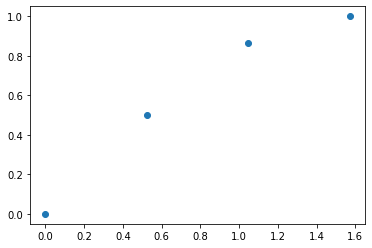

In [16]:
plt.plot(x, y, 'o');

Linearna interpolacija za vrednost pri `x=1.57079633/2`:

In [17]:
y_linearna = lagrange_interpolacija(x=x[-1]/2, x_int=x[1:3], y_int=y[1:3])
y_linearna

0.6830127

Kvadratna:

In [18]:
y_kvadratna = lagrange_interpolacija(x=x[-1]/2, x_int=x[0:3], y_int=y[0:3])
y_kvadratna

0.6997595236464176

Kubična

In [19]:
y_kubična = lagrange_interpolacija(x=x[-1]/2, x_int=x, y_int=y)
y_kubična

0.705889286844634

## Zgled ocene napake

Pri interpolaciji ponavadi funkcije $f(x)$ ne poznamo; zgoraj interpolirane točke pa pripadajo funkciji $y=f(x)=\sin(x)$, vendar pa ne poznamo $\xi$ in zato napako ocenimo s pomočjo formule:

$$e=\frac{f^{(n)}(\xi)}{n!}\,(x-x_0)\,(x-x_1)\,\cdots\,(x-x_n)$$

Ker je v primeru linearne aproksimacije ($n=2$) drugi odvod sinusne funkcije ($f^{(n)}$) med -1 in +1, velja:
$$|e|\le\left|\frac{-1}{2!}\,(\pi/4-\pi/6)\,(\pi/4-\pi/3)\right|=\frac{1}{2}\,\frac{\pi}{12}\,\frac{\pi}{12}=\frac{\pi^2}{288}=0,034$$

Poleg **Lagrangeve metode** bi si tukaj lahko pogledali še **Newtonovo metodo** interpolacije.

## Interpolacija z uporabo `scipy`

Poglejmo si interpolacijo v okviru modula `scipy.interpolate` ([dokumentacija](https://docs.scipy.org/doc/scipy/reference/interpolate.html)).

Uporabili bomo funkcijo za interpoliranje tabele z zlepki, `scipy.interpolate.interp1d` ([dokumentacija](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)):

```python
interp1d(x, y, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)
```

Podati moramo vsaj dva parametra: seznama interpolacijskih točk `x` in `y`. Privzeti parameter `kind='linear'` pomeni, da inteproliramo z odsekoma linearno funkcijo. `interp1d` vrne funkcijo `f`, ki jo kličemo (npr. `y = f(x)`) za izračun interpolirane vrednosti. 

Parameter `kind` je lahko npr. tudi: `'zero'`, `'slinear'`, `'quadratic'` in `'cubic'`; takrat se uporabi interpolacijski zlepek (ang. *spline*) reda 0, 1, 2 oz. 3. Zlepke si bomo pogledali v naslednjem poglavju.

In [20]:
from scipy.interpolate import interp1d

Definirajmo tabelo podatkov:

In [21]:
x = np.array([ 1.        ,  2.14285714,  3.28571429,  4.42857143,  5.57142857,
        6.71428571,  7.85714286,  9.        ])

y = np.array([ 0.84147098,  0.84078711, -0.14362322, -0.95999344, -0.65316501,
        0.41787078,  0.999995  ,  0.41211849])

In [22]:
len(x)

8

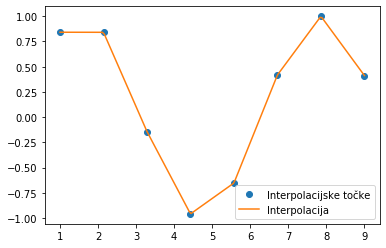

In [23]:
f = interp1d(x, y, kind='linear')
x_g = np.linspace(x[0], x[-1], 20*len(x)-1)
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(x_g, f(x_g), '-', label='Interpolacija')
plt.legend();

# Kubični zlepki

Preden gremo v teorijo zlepkov, si poglejmo rezultat, ki ga dobimo s klicanjem funkcije `interp1d` s parametrom `kind='cubic'` (rezultat je kubični zlepek).

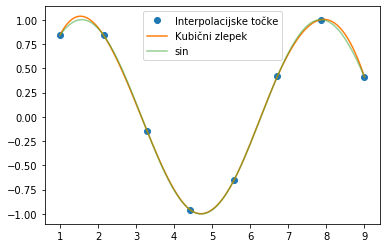

In [24]:
f = interp1d(x, y, kind='cubic')
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(x_g, f(x_g), '-', label='Kubični zlepek')
plt.plot(x_g, np.sin(x_g), label='sin', alpha=0.5)
plt.legend();

Kubični zlepki so pogost način interpolacije. 

Zahtevamo, da je: $x_0<x_1< \cdots <x_n$.

Od točke $x_i$ do $x_{i+1}$ naj bo zlepek 
polinom:

$$f_{i,i+1}(x)= a_{i,3}\,x^3+a_{i,2}\,x^2+a_{i,1}\,x+a_{i,0},$$

pri čemer so neznane vrednosti konstant $a_{i,j}$. 

Če imamo na primer $n+1$ točk, potem je treba določiti $n$ polinomov. 

Celotni zlepek čez $n+1$ točk je definiran z:
$$f(x) = \left\{
\begin{array}{rcl}
f_{0,1}(x); && x\in[x_0, x_1)\\
f_{1,2}(x); && x\in[x_1, x_2)\\
&\vdots&\\
f_{n-1,n}(x); && x\in[x_{n-1}, x_n]
\end{array}
\right.
$$

Vsak polinom $f_{i,i+1}$ je definiran s 4 konstantami $a_{i,j}$; skupaj torej moramo izračunati $4n$ konstant $a_{i,j}$.


**Kako določimo konstante $a_{i,j}$?**

Za določitev $4n$ neznak potrebujemo $4n$ enačb. Poglejmo si, kako jih dobimo:

* $n$ enačb dobimo iz interpolacijskega pogoja: $$y_i=f_{i,i+1}(x_i),\quad i=0,1,2,\dots,n-1$$
* 1 enačbo iz zadnje točke: $$y_n=f_{n-1,n}(x_n)$$
* $3(n-1)$ enačb dobimo iz pogoja $C^2$zveznosti: 
$$\lim_{x\rightarrow x_i^-}f(x)=\lim_{x\rightarrow x_i^+}f(x),$$
$$\lim_{x\rightarrow x_i^-}f'(x)=\lim_{x\rightarrow x_i^+}f'(x)$$
in
$$\lim_{x\rightarrow x_i^-}f''(x)=\lim_{x\rightarrow x_i^+}f''(x).$$

Skupaj imamo definiranih $4n-2$ enačbi, manjkata torej še dve! 

Različni tipi zlepkov se ločijo po tem, kako ti dve enačbi določimo. V nadaljevanju si bomo pogledali *naravne kubične zlepke*.

## Naravni kubični zlepki

*Naravni kubični zlepki* temeljijo na ideji Eulerjevega nosilca:
$$E\,I\,\frac{\textrm{d}^4y}{\textrm{d}x^4}=q(x),$$
kjer je $E$ elastični modul, $I$ drugi moment preseka in $q(x)$ zunanja porazdeljena sila. Ker zunanje porazdeljene sile ni ($q(x)=0$), velja:
$$E\,I\,\frac{\textrm{d}^4y}{\textrm{d}x^4}=0.$$
Sledi, da lahko v vsaki točki tanek nosilec popišemo s polinomom tretje stopnje. 

$C^2$ zveznost je zagotovljena v kolikor so vmesne podpore nosilca členki (moment zato nima nezvezne spremembe).

Manjkajoči 2 neznanki pri naravnih kubičnih zlepkih določimo iz pogoja, da je moment na koncih enak nič (členkasto vpetje):

$$f''(x_{0})=0\qquad\textrm{in}\qquad f''(x_{n})=0$$

Izpeljava je natančneje prikazana v knjigi Kiusalaas J: Numerical Methods in Engineering with Python 3, 2013, stran 120 (glejte tudi J. Petrišič: Interpolacija, Fakulteta za strojništvo, 1999); podrobna izpeljava presega namen te knjige. 

Tukaj si bomo pogledali samo končni rezultat, ki ga lahko izpeljemo ob zgornjih pogojih. V primeru ekvidistantne delitve $h=x_{i+1}-x_i$ tako izpeljemo sistem enačb ($i=1,\dots,n-1$):

$$k_{i-1} + 4 k_{i} + k_{i+1}  =  \frac{6}{h^2} \left(y_{i-1} -2 y_{i} +y_{i+1} \right).$$

kjer je neznanka $k_i$ drugi odvod odsekovne funkcije $k_i = f''_{i,i+1}(x_i)$.

Rešljiv sistem enačb dobimo, če dodamo še robna pogoja za naravne kubične zlepke:

$$k_0=k_n=0.$$

Ko določimo neznake $k_i$, jih uporabimo v odsekoma definirani funkciji:

$$
f_{i,i+1}(x)=\frac{k_i}{6}\left(\frac{(x-x_{i+1})^3}{h}-(x-x_{i+1})\,h\right)
-\frac{k_{i+1}}{6}\left(\frac{(x-x_{i})^3}{h}-(x-x_{i})\,h\right)
+\frac{y_i\,(x-x_{i+1})-y_{i+1}\,(x-x_{i})}{h}.
$$

## Numerična implementacija

Najprej pripravimo funkcijo, katera za podane interpolacijske točke reši sistem linearnih enačb in vrne koeficiente $k_i$:

In [25]:
def kubicni_zlepki_koeficient(x, y):
    """ Vrne koeficiente kubičnih zlepkov `k`, matriko koeficientov `A` in konstant.
    
    x in y predstavljata seznam znanih vrednosti; x mora biti ekvidistanten.
    """
    n = len(x)
    A = np.zeros((n, n)) # pripravimo matriko koeficientov
    h = x[1]-x[0] # korak h
    for i in range(n):
        if i==0 or i==n-1:
            A[i,i] = 1. # k_0 in k_n sta nič zato tukaj damo 1
                       # pri vektorju konstant pa bomo dali 0, k_0 in k_n bosta torej 0
        else:
            A[i, i-1:i+2] = np.asarray([1., 4., 1.])
    b = np.zeros(n)
    b[1:-1] = (6/h**2)*(y[:-2] - 2*y[1:-1] + y[2:]) # desna stran zgornje enačbe
    k = np.linalg.solve(A,b)
    return k, A, b

Opomba: pri zgornjem linarnem problemu, lahko izračun zelo pohitrimo, če upoštevamo tridiagonalnost matrike koeficientov!

Poglejmo si primer izračuna koeficientov:

In [26]:
x = np.asarray([1, 2, 3, 4, 5])
y = np.asarray([0, 1, 0, 1, 0])

k, A, b = kubicni_zlepki_koeficient(x, y)
print('Matrika koeficientov A lin. sistema:\n', A)
print('Vektor konstant b lin. sistema:     ', b)
print('Koeficienti k so:', k)

Matrika koeficientov A lin. sistema:
 [[1. 0. 0. 0. 0.]
 [1. 4. 1. 0. 0.]
 [0. 1. 4. 1. 0.]
 [0. 0. 1. 4. 1.]
 [0. 0. 0. 0. 1.]]
Vektor konstant b lin. sistema:      [  0. -12.  12. -12.   0.]
Koeficienti k so: [ 0.         -4.28571429  5.14285714 -4.28571429  0.        ]


Nato potrebujemo še kubični polinom v določenem intervalu; implementirajmo izraz:

$$
f_{i,i+1}(x)=\frac{k_i}{6}\left(\frac{(x-x_{i+1})^3}{h}-(x-x_{i+1})\,h\right)
-\frac{k_{i+1}}{6}\left(\frac{(x-x_{i})^3}{h}-(x-x_{i})\,h\right)
+\frac{y_i\,(x-x_{i+1})-y_{i+1}\,(x-x_{i})}{h}
$$

In [27]:
def kubicni_zlepki(k, x, y, x_najdi):
    """ Vrne kubicni zlepek pri delitvi `xint`.
    
    :param k: koeficienti kubičnih zlepkov
    :param x in y: znane vrednosti, x mora biti ekvidistanten
    :param x_najdi: vrednosti kjer želimo izračunati kubični zlepek
    """  
    h = x[0] - x[1]
    i = int((x_najdi-x[0])//(-h))
    if i >= len(k)-1:
        i = len(k)-2
    out = ((x_najdi - x[i+1])**3/h - (x_najdi - x[i+1])*h)*k[i]/6.0 \
        - ((x_najdi - x[i])**3/h - (x_najdi - x[i])*h)*k[i+1]/6.0 \
        + (y[i]*(x_najdi - x[i+1]) \
        - y[i+1]*(x_najdi - x[i]))/h
    return out

Izračunamo interpolirane vrednosti:

In [28]:
xint = np.linspace(np.min(x), np.max(x), 50)
yint = np.asarray([kubicni_zlepki(k, x, y, _) for _ in xint])

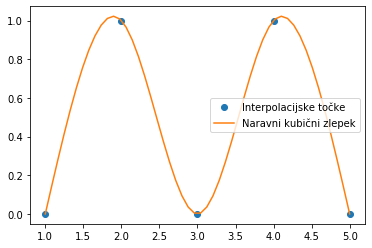

In [29]:
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(xint, yint, label='Naravni kubični zlepek')
plt.legend();

# Nekaj vprašanj za razmislek!


1. Preštudirajte Lagrangevo polinomsko interpolacijo in pripravite funkcijo za Lagrangeve polinome. Pojasnite (z grafičnim prikazom) Lagrangeve polinome.
2. Definirajte funkcijo za Lagrangevo polinomsko interpolacijo. Na primeru pojasnite, kako deluje.
3. Pojasnite teoretično ozadje naravnih kubičnih zlepkov.
4. Naravne kubične zlepke smo izpeljali pod pogojem, da momenta na koncu ni; včasih želimo drugačne pogoje na koncih (npr. znani naklon ali znani moment). Modificirajte na predavanjih predstavljeno kodo za primer, da je na koncih moment $\ne 0$ (predpostavite neko numerično vrednost).
5. Podatke:
    ```python
    x = np.linspace(0, 10, 10)
    y = np.random.rand(10)-0.5
    ```
  interpolirajte z uporabo ``scipy.InterpolatedUnivariateSpline``. Podatke prikažite.
6. Za zgoraj definirane podatke preučite pomoč in najdite vse ničle. Prikažite jih na predhodni sliki.
7. Za zgoraj definirani zlepek izračunajte prvi odvod in ga prikažite.
8. Za zgoraj definirani zlepek izračunajte določeni integral od začetka do konca.
9. Za zgoraj definirane podatke z uporabo vgrajenih funkcij prikažite izračun linearnega in kvadratnega zlepka. Prikažite na sliki.
10. Preučite pomoč za funkcijo ``scipy.interpolate.lagrange`` in k predhodni sliki dodajte Lagrangev interpolacijski polinom. Komentirajte rezultate.
11. Preučite pomoč za funkcijo ``scipy.interpolate.interp1d`` in k predhodni sliki dodajte kvadratni zlepek.
12. Preučite pomoč za funkcijo ``scipy.interpolate.BarycentricInterpolator`` in pojasnite ter prikažite njeno prednost.
13. Preučite pomoč za funkcijo ``scipy.interpolate.KroghInterpolator`` in pojasnite njeno prednost.

## Dodatno

* 2D interpolacija: https://www.youtube.com/watch?v=_cJLVhdj0j4
* Strojno prevajanje: https://pypi.org/project/goslate)

## Nekaj komentarjev modula ``scipy.interpolate``

SciPy ima implementiranih večje število različnih interpolacij ([glejte dokumentacijo](https://docs.scipy.org/doc/scipy/reference/interpolate.html)). S stališča uporabe se bomo tukaj dotaknili  objektne implementacije `scipy.interpolate.InterpolatedUnivariateSpline` ([dokumentacija](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.InterpolatedUnivariateSpline.html)) (starejši pristop temelji na funkcijskem programiranju, glejte  [dokumentacijo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html) `scipy.interpolate.splrep`):

```python
InterpolatedUnivariateSpline(x, y, w=None, bbox=[None, None], k=3, ext=0, check_finite=False)
```

Pri inicializaciji objekta `InterpolatedUnivariateSpline` moramo posredovati interpolacijske točke `x` in `y`. Argument `k` s privzeto vrednostjo `k=3` definira red intepolacijskega zlepka (`1<=k<=5`). Pomemben opcijski parameter je tudi `w`, ki definira uteži posameznim interpolacijskim točkam (uporabimo ga, če želimo določenim področjem dati večji poudarek).

In [30]:
from scipy.interpolate import InterpolatedUnivariateSpline

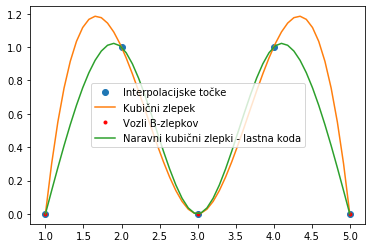

In [31]:
spl = InterpolatedUnivariateSpline(x, y, k=3) # poglejte opcije!
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(xint, spl(xint), label='Kubični zlepek');
plt.plot(spl.get_knots(), spl(spl.get_knots()), 'r.', label='Vozli B-zlepkov')
plt.plot(xint, yint, label='Naravni kubični zlepki - lastna koda');
plt.legend();

Ker gre za B-zlepke, je rezultat drugačen kot tisti, ki smo ga izpeljali z naravnimi kubičnimi zlepki. V nasprotju z naravnimi kubičnimi zlepki, ki imajo vozle (angl. *knots*) v interpolacijskih točkah, se vozli B-zlepkov prilagodijo podatkom. V konkretnem primeru so vozli v točkah:

In [32]:
spl.get_knots()

array([1., 3., 5.])

## Odvajanje, integriranje ... zlepkov

Zlepke lahko odvajamo in integriramo, saj so polinomi. Objekt ``InterpolatedUnivariateSpline`` je tako že pripravljen za odvajanje, integriranje, iskanje korenov (ničel), vozlov ... (glejte [dokumentacijo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.InterpolatedUnivariateSpline.html)).

Za prvi odvod zlepka v objektu `spl` na primer uporabimo metodo ``spl.derivative(1)``, ki vrne nov objekt zlepka (njen red je sedaj za 1 nižji):

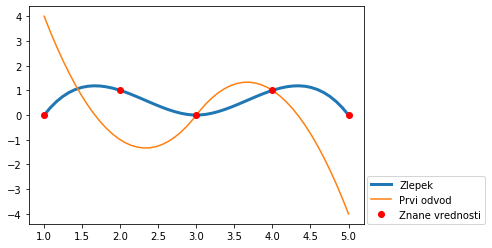

In [33]:
spl1 = spl.derivative(1)
#spl2 = spl.derivative(2)
#spl3 = spl.derivative(3)
plt.plot(xint, spl(xint), lw=3, label='Zlepek')
plt.plot(xint, spl1(xint), label='Prvi odvod')
#plt.plot(xint, spl2(xint), label='Drugi odvod')
#plt.plot(xint, spl3(xint), label='Tretji odvod')
plt.plot(x, y, 'ro', label='Znane vrednosti')
#plt.plot(spl.get_knots(), spl(spl.get_knots()), 'k.', label='Vozli B-zlepka')
plt.legend(loc=(1.01, 0));